###  6.6 Qiskit Implementation
We now implement the Deutsch-Jozsa algorithm for the example of a three-bit function, with both constant and balanced oracles. First let's do our imports:

In [22]:
# Initialization
import numpy as np

# Importing Qiskit modules
from qiskit.providers.basic_provider import BasicProvider
 
backend = BasicProvider().get_backend('basic_simulator')

from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.visualization import plot_histogram
from IPython.display import display

# Set the length of the n-bit input string
n = 3

Let's start by creating a constant oracle, in this case the input has no effect on the output so we just randomly set the output qubit to be 0 or 1:

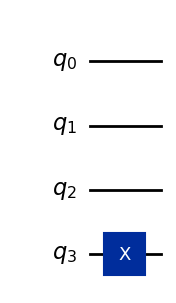

In [23]:
const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw("mpl")

# 4.2 Balanced Oracle

In [24]:
balanced_oracle = QuantumCircuit(n+1)

Next, we create a balanced oracle. As we saw in section 1b, we can create a balanced oracle by performing CNOTs with each input qubit as a control and the output bit as the target. We can vary the input states that give 0 or 1 by wrapping some of the controls in X-gates. Let's first choose a binary string of length n that dictates which controls to wrap:

In [25]:
b_str = "101"

Now we have this string, we can use it as a key to place our X-gates. For each qubit in our circuit, we place an X-gate if the corresponding digit in b_str is 1, or do nothing if the digit is 0.

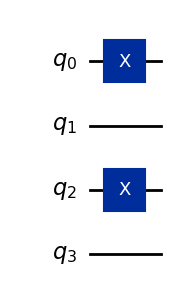

In [26]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw("mpl")

Next, we do our controlled-NOT gates, using each input qubit as a control, and the output qubit as a target:

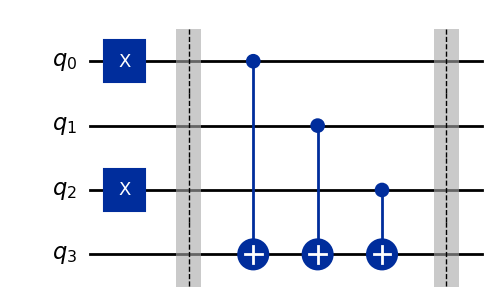

In [27]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
balanced_oracle.draw("mpl")

In [28]:
inally, we repeat the code from two cells up to finish wrapping the controls in X-gates:

SyntaxError: invalid syntax (46863940.py, line 1)

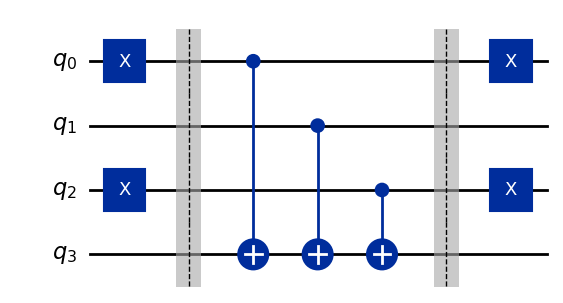

In [29]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw("mpl")

We have just created a balanced oracle! All that's left to do is see if the Deutsch-Jozsa algorithm can solve it.

### 4.3 The Full Algorithm

Let's now put everything together. This first step in the algorithm is to initialize the input qubits in the state |plus> 
 and the output qubit in the |-> state 
:

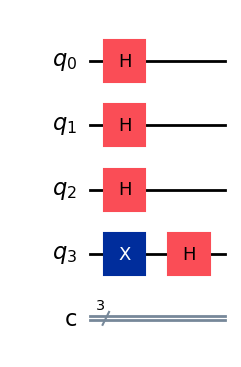

In [30]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw("mpl")

Next, let's apply the oracle. Here we apply the balanced_oracle we created above:

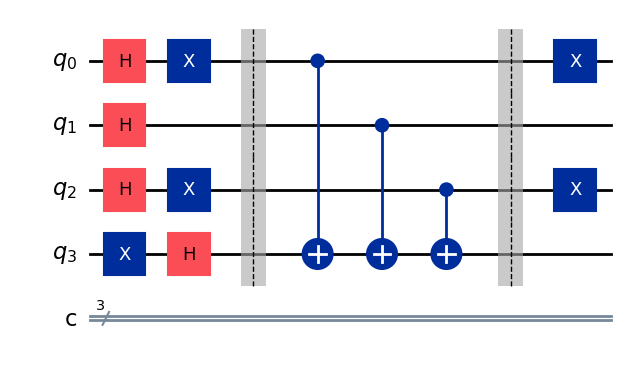

In [31]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit = dj_circuit.compose(balanced_oracle)
dj_circuit.draw("mpl")

Finally, we perform H-gates on the 
n-input qubits, and measure our input register:

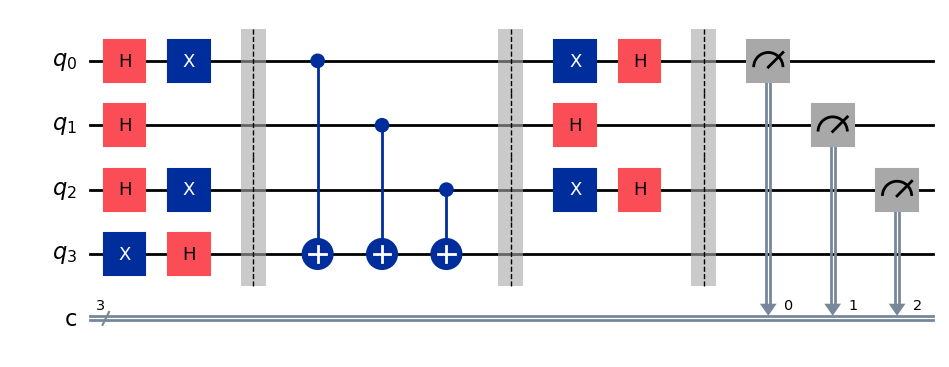

In [32]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit = dj_circuit.compose(balanced_oracle)

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw("mpl")

{'111': 1024}


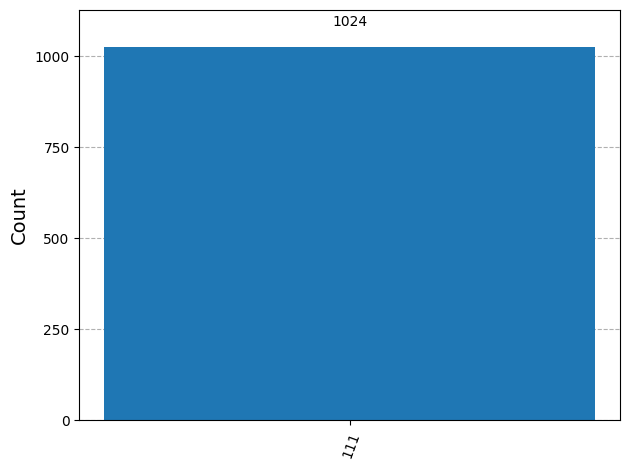

In [33]:
# use local simulator

sim = AerSimulator()
job = sim.run(dj_circuit)

counts = job.result().get_counts()
print(counts)

display(plot_histogram(counts))

In [17]:
# ...we have a 0% chance of measuring 000. 
assert counts.get('000', 0) == 0

We can see from the results above that we have a 0% chance of measuring 000. This correctly predicts the function is balanced.

### 4.4 Generalised Circuits

Below, we provide a generalised function that creates Deutsch-Jozsa oracles and turns them into quantum gates. It takes the case, (either 'balanced' or 'constant', and n, the size of the input register:


In [34]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
                   # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate



Let's also create a function that takes this oracle gate and performs the Deutsch-Jozsa algorithm on it:

In [35]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

Finally, let's use these functions to play around with the algorithm:



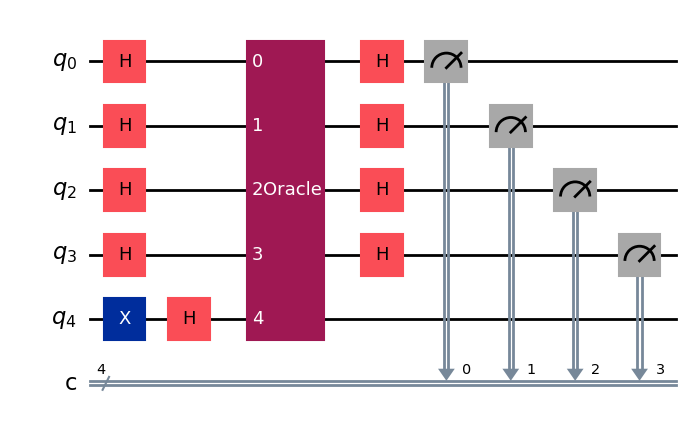

In [36]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw('mpl')

{'1111': 1024}


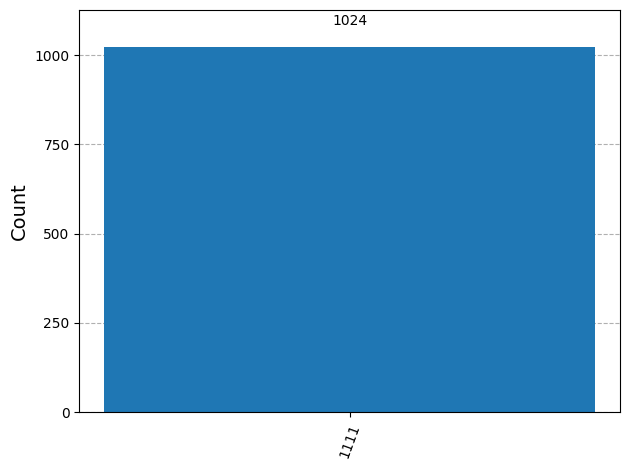

In [37]:
transpiled_dj_circuit = transpile(dj_circuit,  sim)

results = sim.run(transpiled_dj_circuit)

counts = results.result().get_counts()

print(counts)

display(plot_histogram(counts))

In [1]:
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
 
# Bell Circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
 
# Run the sampler job locally using FakeManilaV2
fake_manila = FakeManilaV2()
pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(backend=fake_manila)
result = sampler.run([isa_qc]).result()
 
# Run the sampler job locally using AerSimulator.
# Session syntax is supported but ignored.
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
with Session(backend=aer_sim) as session:
    sampler = Sampler(mode=session)
    result = sampler.run([isa_qc]).result()

TypeError: SamplerV2.__init__() got an unexpected keyword argument 'backend'